# Feature generation for enzymes using Rosetta 

Here, we are determining the thermal stability of about a hundred and fifty point mutants of BglB (model based on 2JIE). After automated mutagensis of the BglB coding sequence, protein production, and protein purification, each mutant's activity at 100 mM pNPG at pH 7.4 at a range of temperatures from 30 C to 50 C was measured using the rate of formation of the pNPG hydrolysis product p-nitrophenol. 

We have expression data for about 150 and Tms for about 70 mutants (along with kinetic constants for another 100 or so). Let's generate some features based on the Rosetta models. 

In [1]:
import pandas

df = pandas.read_csv( 'data/clean/production.csv', index_col='mutant' )
df['pos'] = df.index.str[1:-1].astype( int )
df['designed'] = df.index.str[-1:]
df.drop( 'WT', inplace=True ) 

## Rosetta modeling using `ddg_monomer` 

In [2]:
# makes resfiles for DDG Rosetta app 
#!mkdir ddg/resfiles 

for ( index, series ) in df.iterrows():
    with open( 'protocols/ddg/resfiles/{}'.format( index ), 'w' ) as fn:
        fn.write( 'NATRO\nSTART\n{} A PIKAA {}'.format( series.pos, series.designed ) )

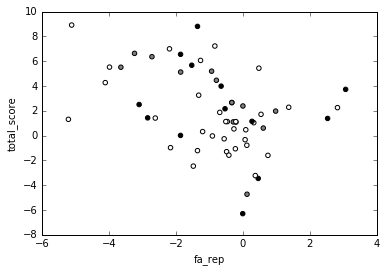

In [3]:
# create pandas-parsable data 

#! ( head -1 protocols/ddg/ddg_predictions.out && grep -v desc protocols/ddg/ddg_predictions.out ) > protocols/ddg/readable_output
ddg_features = pandas.read_csv( 'protocols/results/apo_kellogg.out', sep='\s+', index_col='description' )
J = df.join( ddg_features )

%matplotlib inline
import matplotlib.pyplot as plt 

# colored by expression 

plt.scatter( J.fa_rep, J.total, c=J.protein_on_gel, cmap='gray' )
plt.xlabel( 'fa_rep' )
plt.ylabel( 'total_score' ) 

## Enzyme design features 

### Elastic net for feature selection and prediction of continuous variable $T_M$

In [4]:
# read in and clean up the feature set 

import pandas

def low_10( df ):
    return df.sort_values( [ 'all_cst', 'total_score' ] ).head( 10 ).mean()

models = pandas.read_csv( 'protocols/enzyme_design/scorefile.csv' ) 
grouped = models.groupby( 'name' ).apply( low_10 ) 

df = pandas.read_csv( 'data/clean/production.csv', index_col='mutant' ) 
df['norm_tm'] = df.tm - 39.5

J = df.join( grouped )

# clean up data for sklearn
x_cols = [ u'total_score', u'fa_rep', u'hbond_sc', u'tot_pstat_pm',
       u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
       u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', u'tot_total_charge',
       u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
       u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
       u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
       u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_all_cst', u'SR_2_hbond_pm',
       u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm',
       u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', 
       u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
       u'SR_3_nlpstat_pm', u'SR_4_total_score', u'SR_4_fa_rep',
       u'SR_4_hbond_sc', u'SR_4_hbond_pm',
       u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm',
       u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', u'SR_5_all_cst',
       u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
       u'SR_5_burunsat_pm', 'tm' ]

J = J[ x_cols ]
J.to_csv( 'protocols/enzyme_design/feature_set.csv' ) 

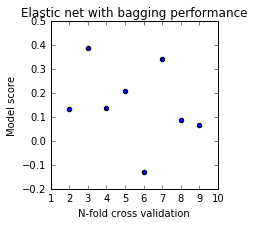

In [6]:
# train and evaluate classifiers for predicting tm 

from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import BaggingRegressor
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.learning_curve import validation_curve
from scipy.stats import pearsonr
import pandas
import matplotlib.pyplot as plt 
%matplotlib inline

# read in data 

df = pandas.read_csv( 'protocols/enzyme_design/feature_set.csv', index_col=0 ).dropna()
df['norm_tm'] = df.tm - 39.5 # BglB native Tm

# construct pipeline 

L = [ 0.03, 0.1, 0.3, 0.9, 0.95, 0.97 ] 

param_grid = [
    { 
        'en__l1_ratio': L, 
        'en__selection': 'random', 
    }, 
]

pln = Pipeline([
    ( 'scaler', preprocessing.StandardScaler() ), 
    ( 'en', BaggingRegressor( ElasticNetCV( cv=10, selection='random' ), n_estimators=1, n_jobs=-1 ) ), 
])

X = df.drop( [ 'tm', 'norm_tm' ], axis=1 ) 
y = df.norm_tm 

plt.figure( figsize=(3, 3) )
plt.title( 'Elastic net with bagging performance' ) 
plt.xlabel( 'N-fold cross validation' ) 
plt.ylabel( 'Model score' ) 

for i in range( 2, 10 ):
    pln.fit( X, y ) 
    score = pln.score( X, y )
    
    plt.scatter( i, score ) 
    plt.plot( i, score, alpha=0.1 ) 

plt.show?

[ 0.875       0.375       0.75        0.75        0.625       0.75
  0.85714286  0.71428571]
[ 0.875       0.75        0.875       0.875       0.625       0.625
  0.85714286  0.85714286]


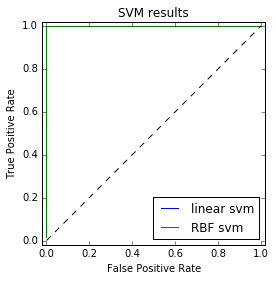

In [9]:
from sklearn import svm, cross_validation
from sklearn.metrics import roc_curve 

df = pandas.read_csv( 'protocols/enzyme_design/feature_set.csv', index_col=0 ).dropna()

X = df.drop( [ 'tm', 'protein_on_gel' ], axis=1 ) 

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform( X ) 

y = df.protein_on_gel.round()

plt.figure( figsize=(4,4) )

classifiers = [
    ( 'linear svm', svm.SVC( kernel='linear', C=0.3 ) ), 
    ( 'RBF svm', svm.SVC( kernel='rbf', C=3. ) ), 
]

legend = []
for name, clf in classifiers:
    
    print cross_validation.cross_val_score( clf, X, y, cv=8 ) 
    
    clf.fit( X, y )
    preds = clf.predict( X ) 
    dec = clf.decision_function( X ) 

    fpr_train, tpr_train, __ = roc_curve( y, dec ) 

    plt.plot( fpr_train, tpr_train ) 
    leg.append( name ) 

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM results')
plt.legend( legend, loc='lower right' )
plt.show()

cross_validation.cross_val_score?

In [10]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC 

pipe_svc = Pipeline